In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xry
import pandas as pd
from matplotlib import gridspec
import warnings # Silence the warnings from SHARPpy
warnings.filterwarnings("ignore")
import sharppy.plot.skew as skew
from matplotlib.ticker import ScalarFormatter, MultipleLocator
from matplotlib.collections import LineCollection
import matplotlib.transforms as transforms
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import interpolate
from scipy import integrate
import scipy.stats
import numpy.ma as ma
import numpy as np
from matplotlib import gridspec
from sharppy.sharptab import winds, utils, params, thermo, interp, profile
from sharppy.io.spc_decoder import SPCDecoder
import sharppy.plot.skew as skew

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

from matplotlib.ticker import ScalarFormatter, MultipleLocator
from matplotlib.collections import LineCollection
import matplotlib.transforms as transforms
import sys
sys.path.insert(0, './tropopauseCalc/')
import tropCalc

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=10, threads_per_worker=2)
client = Client(cluster)

2022-12-15 21:50:08,634 - distributed.diskutils - INFO - Found stale lock file and directory '/data/keeling/a/melinda3/dask-worker-space/worker-pvja9_yo', purging
2022-12-15 21:50:08,637 - distributed.diskutils - INFO - Found stale lock file and directory '/data/keeling/a/melinda3/dask-worker-space/worker-mbw0z_tl', purging
2022-12-15 21:50:08,639 - distributed.diskutils - INFO - Found stale lock file and directory '/data/keeling/a/melinda3/dask-worker-space/worker-4p64hkey', purging
2022-12-15 21:50:08,641 - distributed.diskutils - INFO - Found stale lock file and directory '/data/keeling/a/melinda3/dask-worker-space/worker-_0fd1cc0', purging
2022-12-15 21:50:08,644 - distributed.diskutils - INFO - Found stale lock file and directory '/data/keeling/a/melinda3/dask-worker-space/worker-sezs0vy3', purging
2022-12-15 21:50:08,646 - distributed.diskutils - INFO - Found stale lock file and directory '/data/keeling/a/melinda3/dask-worker-space/worker-kn2k5klk', purging
2022-12-15 21:50:08,64

In [3]:
#Load the data
scout1 = xry.open_dataset('./NASA/uiucformat_nc_1.3/SCOUT1_griddedsounding.nc')
scout2 = xry.open_dataset('./NASA/uiucformat_nc_1.3/SCOUT2_griddedsounding.nc')
scout3 = xry.open_dataset('./NASA/uiucformat_nc_1.3/SCOUT3_griddedsounding.nc')
m1 = xry.open_dataset('./NASA/uiucformat_nc_1.3/M1_griddedsounding.nc')
cordoba = xry.open_dataset('./NASA/uiucformat_nc_1.3/Cordoba_griddedsounding.nc')
dow8 = xry.open_dataset('./NASA/uiucformat_nc_1.3/DOW8_griddedsounding.nc')
ezeiza = xry.open_dataset('./NASA/uiucformat_nc_1.3/Ezeiza_griddedsounding.nc')
mendoza = xry.open_dataset('./NASA/uiucformat_nc_1.3/Mendoza_griddedsounding.nc')
resistencia = xry.open_dataset('./NASA/uiucformat_nc_1.3/Resistencia_griddedsounding.nc')
s1 = xry.open_dataset('./NASA/uiucformat_nc_1.3/S1_griddedsounding.nc')
sbj = xry.open_dataset('./NASA/uiucformat_nc_1.3/SBJ_griddedsounding.nc')

scout2

<xarray.Dataset>
Dimensions:      (pressure: 263, launch time: 94)
Coordinates:
  * pressure     (pressure) float64 65.0 70.0 75.0 80.0 ... 975.0 975.8 976.7
  * launch time  (launch time) datetime64[ns] 2018-12-16T21:00:00 ... 2018-11...
Data variables: (12/23)
    Time         (launch time, pressure) float64 ...
    Temp         (launch time, pressure) float64 ...
    Dewpt        (launch time, pressure) float64 ...
    RH           (launch time, pressure) float64 ...
    Ucmp         (launch time, pressure) float64 ...
    Vcmp         (launch time, pressure) float64 ...
    ...           ...
    Qu           (launch time, pressure) float64 ...
    Qv           (launch time, pressure) float64 ...
    QdZ          (launch time, pressure) float64 ...
    llat         (launch time) object ...
    llon         (launch time) object ...
    lalt         (launch time) float64 ...

In [4]:
scout1 = scout1.rename({'launch time':'launch_time'})
scout1 = scout1.sortby('launch_time', ascending=True)
scout2 = scout2.rename({'launch time': 'launch_time'})
scout2 = scout2.sortby('launch_time', ascending=True)
scout3 = scout3.rename({'launch time':'launch_time'})
scout3 = scout3.sortby('launch_time', ascending=True)
m1 = m1.rename({'launch time': 'launch_time'})
cordoba = cordoba.rename({'launch time':'launch_time'})
dow8 = dow8.rename({'launch time':'launch_time'})
ezeiza = ezeiza.rename({'launch time':'launch_time'})
mendoza = mendoza.rename({'launch time':'launch_time'})
resistencia = resistencia.rename({'launch time':'launch_time'})
s1 = s1.rename({'launch time':'launch_time'})
sbj = sbj.rename({'launch time':'launch_time'})


In [5]:
#Loop through the Skew-T files and create a spaghetti plot of the profiles

def profile_loop_plotter(skews):

    
    """
    This function plots observed sounding data for a range of time on the same Skew-T to improve analysis
    of the UT/LS over time from observations
    """
    obs_temp = np.flip(np.array(skews.Temp[:]))
    obs_dew = np.flip(np.array(skews.Dewpt[:]))
    obs_pres = np.flip(np.array(skews.pressure))
    obs_ucomp = np.flip(np.array(skews.Ucmp[:]))
    obs_vcomp = np.flip(np.array(skews.Vcmp[:]))
    obs_alt = np.flip(np.array(skews.Alt[:]))

    obs_temp_nan = (~np.isnan(obs_temp))
    lats = skews.Lat[obs_temp_nan]
    lat = lats[0]
    lons = skews.Lon[obs_temp_nan]
    lon = lons[0]
    
    obs_temp = obs_temp[obs_temp_nan]
    obs_temp_k = obs_temp + 273
    obs_pres = obs_pres[obs_temp_nan]
    obs_dew = obs_dew[obs_temp_nan]

    obs_ucomp = obs_ucomp[obs_temp_nan] *units.meter/units.second
    obs_vcomp= obs_vcomp[obs_temp_nan] * units.meter/units.second
    obs_alt = obs_alt[obs_temp_nan]

    obs_alt_nan = (~np.isnan(obs_alt))
    obs_temp = obs_temp[obs_alt_nan]
    obs_pres = obs_pres[obs_alt_nan]

    obs_dew = obs_dew[obs_alt_nan]
    obs_ucomp = obs_ucomp[obs_alt_nan]
    obs_vcomp = obs_vcomp[obs_alt_nan]
    obs_alt = obs_alt[obs_alt_nan]
    ot_len = np.array(len(obs_alt))
    dz = [obs_alt[ind+1] - obs_alt[ind] for ind in range(ot_len-1)]

    #Calculate wind speed and direction
    wind_direction2= mpcalc.wind_direction(obs_ucomp, obs_vcomp, convention = 'from')
    wind_speed2 = mpcalc.wind_speed(obs_ucomp, obs_vcomp)

    #Filter out soundings that don't reach at least 250mb
        
    prof = profile.create_profile(profile='default', pres=obs_pres, hght=obs_alt, tmpc=obs_temp, \
                                    dwpc=obs_dew, wspd = wind_speed2, wdir = wind_direction2, missing=-9999, strictQC=False)

    mupcl = params.parcelx(prof, flag=3 ) # Most-Unstable Parcel
    mucape = mupcl.bplus
    el = mupcl.elpres
    theta = mpcalc.potential_temperature(obs_pres*units.mbar, obs_temp*units.degC)
    #Lapse Rate
    lapse_rate =[]
    pres=[]
    press=[]
    for a in obs_pres:
        lapse_rate.append(params.lapse_rate(prof, a, a+1))
    

     #Determine the height of the tropopause, based on WMO definition from Birner et al. (2010)  
    pres_out = tropCalc.wmo(obs_pres*units.millibar, obs_temp_k*units.K, lapseC=2*units.K/units.km)
    #Get the lapse rate at the closest level to the tropopause
    
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx

    lapse_out = lapse_rate[find_nearest(obs_pres, pres_out.magnitude)]
    lat_tp = lats[find_nearest(obs_pres, pres_out.magnitude)]
    lon_tp = lons[find_nearest(obs_pres, pres_out.magnitude)]

    #Select several data points from the profiles to feed into the machine learning algorithm

    t500 = obs_temp_k[find_nearest(obs_pres, 500)]
    t850 = obs_temp_k[find_nearest(obs_pres, 850)]
    t250 = obs_temp_k[find_nearest(obs_pres, 250)]
    rh850 = obs_dew[find_nearest(obs_pres, 850)]
    rh500 = obs_dew[find_nearest(obs_pres, 500)]
    rh250 = obs_dew[find_nearest(obs_pres, 250)]
    w850 = wind_speed2[find_nearest(obs_pres, 850)]
    w500 = wind_speed2[find_nearest(obs_pres, 500)]
    w250 = wind_speed2[find_nearest(obs_pres, 250)]
    
    """       
    
        # Let's set the y-axis bounds of the plot and create the profile to plot
        #Pressure level data sounding
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111, projection='skewx')
    ax1.grid(True)
    
    pmax = 1000
    pmin = 10
    dp = -10
    presvals = np.arange(int(pmax), int(pmin)+dp, dp)

    pcl = mupcl

    for t in np.arange(-10,45,5):
        tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
        # Plot the moist-adiabat with a black line that is faded a bit.
    ax1.semilogy(tw, presvals, 'k-', alpha=.2)
    ax1.axhline(pres_out, -10, 45)
    ax1.semilogy(prof.tmpc, prof.pres, 'r', lw=2)
    ax1.semilogy(prof.dwpc, prof.pres, 'g', lw=2) 


    ax1.yaxis.set_major_formatter(plt.ScalarFormatter())
    ax1.set_yticks(np.linspace(100,1000,10))
    ax1.set_ylim(1020,30)

    ax1.xaxis.set_major_locator(plt.MultipleLocator(10))
    ax1.set_xlim(-55,40)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(fontsize = 20, loc = 'best')"""
    return lapse_out, pres_out.magnitude,lat_tp.values, lon_tp.values, lat.values, lon.values, t850, t500, t250, rh850, rh500, rh250, w850.magnitude, w500.magnitude, w250.magnitude

   
  


In [ ]:
lapse_res = []
trop_pres_res = []
lat_res = []
lon_res = []
lat_tp_res = []
lon_tp_res = []
t850_res = []
t500_res = []
t250_res = []
rh850_res = []
rh500_res = []
rh250_res = []
w850_res = []
w500_res = []
w250_res = []

for time in resistencia.launch_time:
    lapse_res.append(profile_loop_plotter(resistencia.sel(launch_time = time, method='nearest'))[0])
    trop_pres_res.append(profile_loop_plotter(resistencia.sel(launch_time = time, method='nearest'))[1])
    lat_res.append(profile_loop_plotter(resistencia.sel(launch_time = time, method='nearest'))[2])
    lon_res.append(profile_loop_plotter(resistencia.sel(launch_time = time, method='nearest'))[3])
    lat_tp_res.append(profile_loop_plotter(resistencia.sel(launch_time = time, method='nearest'))[4])
    lon_tp_res.append(profile_loop_plotter(resistencia.sel(launch_time = time, method='nearest'))[5])
    t850_res.append(profile_loop_plotter(resistencia.sel(launch_time = time, method='nearest'))[6])
    t500_res.append(profile_loop_plotter(resistencia.sel(launch_time = time, method='nearest'))[7])
    t250_res.append(profile_loop_plotter(resistencia.sel(launch_time = time, method='nearest'))[8])
    rh850_res.append(profile_loop_plotter(resistencia.sel(launch_time = time, method='nearest'))[9])
    rh500_res.append(profile_loop_plotter(resistencia.sel(launch_time = time, method='nearest'))[10])
    rh250_res.append(profile_loop_plotter(resistencia.sel(launch_time = time, method='nearest'))[11])
    w850_res.append(profile_loop_plotter(resistencia.sel(launch_time = time, method='nearest'))[12])
    w500_res.append(profile_loop_plotter(resistencia.sel(launch_time = time, method='nearest'))[13])
    w250_res.append(profile_loop_plotter(resistencia.sel(launch_time = time, method='nearest'))[14])


res_dict = {'lapse_rate_tropopause':lapse_res, 'trop_pres':trop_pres_res,\
            'lat_launch':lat_res, 'lon_launch':lon_res, 'lat_tp':lat_tp_res, 'lon_tp':lon_tp_res,\
            't850':t850_res, 't500':t500_res, 't250':t250_res, 'rh850':rh850_res, 'rh500':rh500_res,\
            'rh250':rh250_res, 'w850':w850_res, 'w500':w500_res, 'w250':w250_res}
res_data = pd.DataFrame(res_dict, index=resistencia.launch_time)
res_data.to_csv('./NASA/RELAMPAGO_soundings/res_processed.csv')
        



Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause no

In [ ]:
res_data

In [19]:
lapse_dow8 = []
trop_pres_dow8 = []
lat_dow8 = []
lon_dow8 = []
lat_tp_dow8 = []
lon_tp_dow8 = []
t850_dow8 = []
t500_dow8 = []
t250_dow8 = []
rh850_dow8 = []
rh500_dow8 = []
rh250_dow8 = []
w850_dow8 = []
w500_dow8 = []
w250_dow8 = []

for time in dow8.launch_time:
    lapse_dow8.append(profile_loop_plotter(dow8.sel(launch_time = time, method='nearest'))[0])
    trop_pres_dow8.append(profile_loop_plotter(dow8.sel(launch_time = time, method='nearest'))[1])
    lat_dow8.append(profile_loop_plotter(dow8.sel(launch_time = time, method='nearest'))[2])
    lon_dow8.append(profile_loop_plotter(dow8.sel(launch_time = time, method='nearest'))[3])
    lat_tp_dow8.append(profile_loop_plotter(dow8.sel(launch_time = time, method='nearest'))[4])
    lon_tp_dow8.append(profile_loop_plotter(dow8.sel(launch_time = time, method='nearest'))[5])
    t850_dow8.append(profile_loop_plotter(dow8.sel(launch_time = time, method='nearest'))[6])
    t500_dow8.append(profile_loop_plotter(dow8.sel(launch_time = time, method='nearest'))[7])
    t250_dow8.append(profile_loop_plotter(dow8.sel(launch_time = time, method='nearest'))[8])
    rh850_dow8.append(profile_loop_plotter(dow8.sel(launch_time = time, method='nearest'))[9])
    rh500_dow8.append(profile_loop_plotter(dow8.sel(launch_time = time, method='nearest'))[10])
    rh250_dow8.append(profile_loop_plotter(dow8.sel(launch_time = time, method='nearest'))[11])
    w850_dow8.append(profile_loop_plotter(dow8.sel(launch_time = time, method='nearest'))[12])
    w500_dow8.append(profile_loop_plotter(dow8.sel(launch_time = time, method='nearest'))[13])
    w250_dow8.append(profile_loop_plotter(dow8.sel(launch_time = time, method='nearest'))[14])
        
dow8_dict = {'lapse_rate_tropopause':lapse_dow8, 'trop_pres':trop_pres_dow8,\
            'lat_launch':lat_dow8, 'lon_launch':lon_dow8, 'lat_tp':lat_tp_dow8,'lon_tp':lon_tp_dow8,\
            't850':t850_dow8, 't500':t500_dow8, 't250':t250_dow8, 'rh850':rh850_dow8, 'rh500':rh500_dow8,\
            'rh250':rh250_dow8, 'w850':w850_dow8, 'w500':w500_dow8, 'w250':w250_dow8}
dow8_data = pd.DataFrame(dow8_dict, index=dow8.launch_time)
dow8_data.to_csv('./NASA/RELAMPAGO_soundings/dow8_processed.csv')


Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found


In [6]:
lapse_eiz = []
trop_pres_eiz = []
lat_eiz = []
lon_eiz = []
lat_tp_eiz = []
lon_tp_eiz = []
t850_eiz = []
t500_eiz = []
t250_eiz = []
rh850_eiz = []
rh500_eiz = []
rh250_eiz = []
w850_eiz = []
w500_eiz = []
w250_eiz = []

for time in ezeiza.launch_time:
    lapse_eiz.append(profile_loop_plotter(ezeiza.sel(launch_time = time, method='nearest'))[0])
    trop_pres_eiz.append(profile_loop_plotter(ezeiza.sel(launch_time = time, method='nearest'))[1])
    lat_eiz.append(profile_loop_plotter(ezeiza.sel(launch_time = time, method='nearest'))[2])
    lon_eiz.append(profile_loop_plotter(ezeiza.sel(launch_time = time, method='nearest'))[3])
    lat_tp_eiz.append(profile_loop_plotter(ezeiza.sel(launch_time = time, method='nearest'))[4])
    lon_tp_eiz.append(profile_loop_plotter(ezeiza.sel(launch_time = time, method='nearest'))[5])
    t850_eiz.append(profile_loop_plotter(ezeiza.sel(launch_time = time, method='nearest'))[6])
    t500_eiz.append(profile_loop_plotter(ezeiza.sel(launch_time = time, method='nearest'))[7])
    t250_eiz.append(profile_loop_plotter(ezeiza.sel(launch_time = time, method='nearest'))[8])
    rh850_eiz.append(profile_loop_plotter(ezeiza.sel(launch_time = time, method='nearest'))[9])
    rh500_eiz.append(profile_loop_plotter(ezeiza.sel(launch_time = time, method='nearest'))[10])
    rh250_eiz.append(profile_loop_plotter(ezeiza.sel(launch_time = time, method='nearest'))[11])
    w850_eiz.append(profile_loop_plotter(ezeiza.sel(launch_time = time, method='nearest'))[12])
    w500_eiz.append(profile_loop_plotter(ezeiza.sel(launch_time = time, method='nearest'))[13])
    w250_eiz.append(profile_loop_plotter(ezeiza.sel(launch_time = time, method='nearest'))[14])
        
eiz_dict = {'lapse_rate_tropopause':lapse_eiz, 'trop_pres':trop_pres_eiz,\
            'lat_launch':lat_eiz, 'lon_launch':lon_eiz, 'lat_tp':lat_tp_eiz, 'lon_tp':lon_tp_eiz,\
            't850':t850_eiz, 't500':t500_eiz, 't250':t250_eiz, 'rh850':rh850_eiz, 'rh500':rh500_eiz,\
            'rh250':rh250_eiz, 'w850':w850_eiz, 'w500':w500_eiz, 'w250':w250_eiz}
eiz_data = pd.DataFrame(eiz_dict, index=ezeiza.launch_time)
eiz_data.to_csv('./NASA/RELAMPAGO_soundings/eiz_processed.csv')


Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause no

In [7]:
lapse_men = []
trop_pres_men = []
lat_men = []
lon_men = []
lat_tp_men = []
lon_tp_men = []
t850_men = []
t500_men = []
t250_men = []
rh850_men = []
rh500_men = []
rh250_men = []
w850_men = []
w500_men = []
w250_men = []

for time in mendoza.launch_time:
    lapse_men.append(profile_loop_plotter(mendoza.sel(launch_time = time, method='nearest'))[0])
    trop_pres_men.append(profile_loop_plotter(mendoza.sel(launch_time = time, method='nearest'))[1])
    lat_men.append(profile_loop_plotter(mendoza.sel(launch_time = time, method='nearest'))[2])
    lon_men.append(profile_loop_plotter(mendoza.sel(launch_time = time, method='nearest'))[3])
    lat_tp_men.append(profile_loop_plotter(mendoza.sel(launch_time = time, method='nearest'))[4])
    lon_tp_men.append(profile_loop_plotter(mendoza.sel(launch_time = time, method='nearest'))[5])
    t850_men.append(profile_loop_plotter(mendoza.sel(launch_time = time, method='nearest'))[6])
    t500_men.append(profile_loop_plotter(mendoza.sel(launch_time = time, method='nearest'))[7])
    t250_men.append(profile_loop_plotter(mendoza.sel(launch_time = time, method='nearest'))[8])
    rh850_men.append(profile_loop_plotter(mendoza.sel(launch_time = time, method='nearest'))[9])
    rh500_men.append(profile_loop_plotter(mendoza.sel(launch_time = time, method='nearest'))[10])
    rh250_men.append(profile_loop_plotter(mendoza.sel(launch_time = time, method='nearest'))[11])
    w850_men.append(profile_loop_plotter(mendoza.sel(launch_time = time, method='nearest'))[12])
    w500_men.append(profile_loop_plotter(mendoza.sel(launch_time = time, method='nearest'))[13])
    w250_men.append(profile_loop_plotter(mendoza.sel(launch_time = time, method='nearest'))[14])

men_dict = {'lapse_rate_tropopause':lapse_men, 'trop_pres':trop_pres_men,\
            'lat_launch':lat_men,'lon_launch':lon_men, 'lat_tp':lat_tp_men, 'lon_tp':lon_tp_men,\
            't850':t850_men, 't500':t500_men, 't250':t250_men, 'rh850':rh850_men, 'rh500':rh500_men,\
            'rh250':rh250_men, 'w850':w850_men, 'w500':w500_men, 'w250':w250_men}
men_data = pd.DataFrame(men_dict, index=mendoza.launch_time)
men_data.to_csv('./NASA/RELAMPAGO_soundings/men_processed.csv')    



Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause no

In [8]:
lapse_sbj = []
trop_pres_sbj = []
lat_sbj = []
lon_sbj = []
lat_tp_sbj = []
lon_tp_sbj = []
t850_sbj = []
t500_sbj = []
t250_sbj = []
rh850_sbj = []
rh500_sbj = []
rh250_sbj = []
w850_sbj = []
w500_sbj = []
w250_sbj = []

for time in sbj.launch_time:
    lapse_sbj.append(profile_loop_plotter(sbj.sel(launch_time = time, method='nearest'))[0])
    trop_pres_sbj.append(profile_loop_plotter(sbj.sel(launch_time = time, method='nearest'))[1])
    lat_sbj.append(profile_loop_plotter(sbj.sel(launch_time = time, method='nearest'))[2])
    lon_sbj.append(profile_loop_plotter(sbj.sel(launch_time = time, method='nearest'))[3])
    lat_tp_sbj.append(profile_loop_plotter(sbj.sel(launch_time = time, method='nearest'))[4])
    lon_tp_sbj.append(profile_loop_plotter(sbj.sel(launch_time = time, method='nearest'))[5])
    t850_sbj.append(profile_loop_plotter(sbj.sel(launch_time = time, method='nearest'))[6])
    t500_sbj.append(profile_loop_plotter(sbj.sel(launch_time = time, method='nearest'))[7])
    t250_sbj.append(profile_loop_plotter(sbj.sel(launch_time = time, method='nearest'))[8])
    rh850_sbj.append(profile_loop_plotter(sbj.sel(launch_time = time, method='nearest'))[9])
    rh500_sbj.append(profile_loop_plotter(sbj.sel(launch_time = time, method='nearest'))[10])
    rh250_sbj.append(profile_loop_plotter(sbj.sel(launch_time = time, method='nearest'))[11])
    w850_sbj.append(profile_loop_plotter(sbj.sel(launch_time = time, method='nearest'))[12])
    w500_sbj.append(profile_loop_plotter(sbj.sel(launch_time = time, method='nearest'))[13])
    w250_sbj.append(profile_loop_plotter(sbj.sel(launch_time = time, method='nearest'))[14])


sbj_dict = {'lapse_rate_tropopause':lapse_sbj, 'trop_pres':trop_pres_sbj,\
            'lat_launch':lat_sbj, 'lon_launch':lon_sbj, 'lat_tp':lat_tp_sbj, 'lon_tp':lon_tp_sbj,\
            't850':t850_sbj, 't500':t500_sbj, 't250':t250_sbj, 'rh850':rh850_sbj, 'rh500':rh500_sbj,\
            'rh250':rh250_sbj, 'w850':w850_sbj, 'w500':w500_sbj, 'w250':w250_sbj}
sbj_data = pd.DataFrame(sbj_dict, index=sbj.launch_time)
sbj_data.to_csv('./NASA/RELAMPAGO_soundings/sbj_processed.csv')
        



Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause no

In [6]:
lapse_s1 = []
trop_pres_s1 = []
lat_s1 = []
lon_s1 = []
lat_tp_s1 = []
lon_tp_s1 = []
t850_s1 = []
t500_s1 = []
t250_s1 = []
rh850_s1 = []
rh500_s1 = []
rh250_s1 = []
w850_s1 = []
w500_s1 = []
w250_s1 = []

for time in s1.launch_time:
    lapse_s1.append(profile_loop_plotter(s1.sel(launch_time = time, method='nearest'))[0])
    trop_pres_s1.append(profile_loop_plotter(s1.sel(launch_time = time, method='nearest'))[1])
    lat_s1.append(profile_loop_plotter(s1.sel(launch_time = time, method='nearest'))[2])
    lon_s1.append(profile_loop_plotter(s1.sel(launch_time = time, method='nearest'))[3])
    lat_tp_s1.append(profile_loop_plotter(s1.sel(launch_time = time, method='nearest'))[4])
    lon_tp_s1.append(profile_loop_plotter(s1.sel(launch_time = time, method='nearest'))[5])    
    t850_s1.append(profile_loop_plotter(s1.sel(launch_time = time, method='nearest'))[6])
    t500_s1.append(profile_loop_plotter(s1.sel(launch_time = time, method='nearest'))[7])
    t250_s1.append(profile_loop_plotter(s1.sel(launch_time = time, method='nearest'))[8])
    rh850_s1.append(profile_loop_plotter(s1.sel(launch_time = time, method='nearest'))[9])
    rh500_s1.append(profile_loop_plotter(s1.sel(launch_time = time, method='nearest'))[10])
    rh250_s1.append(profile_loop_plotter(s1.sel(launch_time = time, method='nearest'))[11])
    w850_s1.append(profile_loop_plotter(s1.sel(launch_time = time, method='nearest'))[12])
    w500_s1.append(profile_loop_plotter(s1.sel(launch_time = time, method='nearest'))[13])
    w250_s1.append(profile_loop_plotter(s1.sel(launch_time = time, method='nearest'))[14])


s1_dict = {'lapse_rate_tropopause':lapse_s1, 'trop_pres':trop_pres_s1,\
            'lat_launch':lat_s1, 'lon_launch':lon_s1, 'lat_tp':lat_tp_s1, 'lon_tp':lon_tp_s1,\
            't850':t850_s1, 't500':t500_s1, 't250':t250_s1, 'rh850':rh850_s1, 'rh500':rh500_s1,\
            'rh250':rh250_s1, 'w850':w850_s1, 'w500':w500_s1, 'w250':w250_s1}
s1_data = pd.DataFrame(s1_dict, index=s1.launch_time)
s1_data.to_csv('./NASA/RELAMPAGO_soundings/s1_processed.csv')
        



Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause no

In [8]:
lapse = []
trop_pres = []
lat = []
lon = []
lat_tp = []
lon_tp = []
t850 = []
t500 = []
t250 = []
rh850 = []
rh500 = []
rh250 = []
w850 = []
w500 = []
w250 = []

for time in m1.launch_time:
    lapse.append(profile_loop_plotter(m1.sel(launch_time = time, method='nearest'))[0])
    trop_pres.append(profile_loop_plotter(m1.sel(launch_time = time, method='nearest'))[1])
    lat.append(profile_loop_plotter(m1.sel(launch_time = time, method='nearest'))[2])
    lon.append(profile_loop_plotter(m1.sel(launch_time = time, method='nearest'))[3])
    lat_tp.append(profile_loop_plotter(m1.sel(launch_time = time, method='nearest'))[4])
    lon_tp.append(profile_loop_plotter(m1.sel(launch_time = time, method='nearest'))[5])
    t850.append(profile_loop_plotter(m1.sel(launch_time = time, method='nearest'))[6])
    t500.append(profile_loop_plotter(m1.sel(launch_time = time, method='nearest'))[7])
    t250.append(profile_loop_plotter(m1.sel(launch_time = time, method='nearest'))[8])
    rh850.append(profile_loop_plotter(m1.sel(launch_time = time, method='nearest'))[9])
    rh500.append(profile_loop_plotter(m1.sel(launch_time = time, method='nearest'))[10])
    rh250.append(profile_loop_plotter(m1.sel(launch_time = time, method='nearest'))[11])
    w850.append(profile_loop_plotter(m1.sel(launch_time = time, method='nearest'))[12])
    w500.append(profile_loop_plotter(m1.sel(launch_time = time, method='nearest'))[13])
    w250.append(profile_loop_plotter(m1.sel(launch_time = time, method='nearest'))[14])


m1_dict = {'lapse_rate_tropopause':lapse, 'trop_pres':trop_pres,\
            'lat_launch':lat, 'lon_launch':lon, 'lat_tp':lat_tp, 'lon_tp':lon_tp,\
            't850':t850, 't500':t500, 't250':t250, 'rh850':rh850, 'rh500':rh500,\
            'rh250':rh250, 'w850':w850, 'w500':w500, 'w250':w250}
m1_data = pd.DataFrame(m1_dict, index=m1.launch_time)
m1_data.to_csv('./NASA/RELAMPAGO_soundings/m1_processed.csv')
        



Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause no

In [9]:
lapse_cor = []
trop_pres_cor = []
lat_cor = []
lon_cor = []
lat_tp_cor = []
lon_tp_cor = []
t850_cor = []
t500_cor = []
t250_cor = []
rh850_cor = []
rh500_cor = []
rh250_cor = []
w850_cor = []
w500_cor = []
w250_cor = []

for time_cor in cordoba.launch_time:
    lapse_cor.append(profile_loop_plotter(cordoba.sel(launch_time = time_cor, method='nearest'))[0])
    trop_pres_cor.append(profile_loop_plotter(cordoba.sel(launch_time = time_cor, method='nearest'))[1])
    lat_cor.append(profile_loop_plotter(cordoba.sel(launch_time = time_cor, method='nearest'))[2])
    lon_cor.append(profile_loop_plotter(cordoba.sel(launch_time = time_cor, method='nearest'))[3])
    lat_tp_cor.append(profile_loop_plotter(cordoba.sel(launch_time = time_cor, method='nearest'))[4])
    lon_tp_cor.append(profile_loop_plotter(cordoba.sel(launch_time = time_cor, method='nearest'))[5])
    t850_cor.append(profile_loop_plotter(cordoba.sel(launch_time = time, method='nearest'))[6])
    t500_cor.append(profile_loop_plotter(cordoba.sel(launch_time = time, method='nearest'))[7])
    t250_cor.append(profile_loop_plotter(cordoba.sel(launch_time = time, method='nearest'))[8])
    rh850_cor.append(profile_loop_plotter(cordoba.sel(launch_time = time, method='nearest'))[9])
    rh500_cor.append(profile_loop_plotter(cordoba.sel(launch_time = time, method='nearest'))[10])
    rh250_cor.append(profile_loop_plotter(cordoba.sel(launch_time = time, method='nearest'))[11])
    w850_cor.append(profile_loop_plotter(cordoba.sel(launch_time = time, method='nearest'))[12])
    w500_cor.append(profile_loop_plotter(cordoba.sel(launch_time = time, method='nearest'))[13])
    w250_cor.append(profile_loop_plotter(cordoba.sel(launch_time = time, method='nearest'))[14])


cor_dict = {'lapse_rate_tropopause':lapse_cor, 'trop_pres':trop_pres_cor,\
            'lat_launch':lat_cor, 'lon_launch':lon_cor, 'lat_tp':lat_tp_cor, 'lon_tp':lon_tp_cor,\
            't850':t850_cor, 't500':t500_cor, 't250':t250_cor, 'rh850':rh850_cor, 'rh500':rh500_cor,\
            'rh250':rh250_cor, 'w850':w850_cor, 'w500':w500_cor, 'w250':w250_cor}
cor_data = pd.DataFrame(cor_dict, index=cordoba.launch_time)
cor_data.to_csv('./NASA/RELAMPAGO_soundings/cor_processed.csv')
        



Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause no

In [131]:
scout1.Temp[15, :].data

array([  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan, -46.5, -44.8, -43.1, -41.1, -39.7, -38.7, -37.6, -36.3,
       -35.4, -34.5, -33.7, -32.8, -31.7, -31. , -29.9, -28.9, -28. ,
       -27.1, -26.5, -26. , -25.2, -24. , -23.4, -22.7, -20.5, -20.8,
       -22. , -21.3, -20.9, -21.4, -21.2, -20.4, -19.7, -19.1, -18.4,
       -17.7, -17. , -16.3, -15.6, -15. , -14.5, -14.3, -14.1, -13.8,
       -13.5, -13.5, -13.5, -13.3, -13. ,  -9.2,  -6.9,  -6.4,  -8.5,
        -8.1,  -8.4,  -7.7,  -7.1,  -6.5,  -5.9,  -5.2,  -4.4,  -4. ,
        -3.7,  -3.1,  -2.5,  -2.2,  -1.8,  -1.4,  -1.2,   0.4,   1.6,
         1.9,   2.6,   3.7,   4.1,   4.6,   5.1,   5.7,   6.2,   6.6,
         7. ,   7.3,   7.6,   7.9,   8.1,   8.3,   8.4,   8.7,   9. ,
         9.3,   9.5,

In [130]:
scout1.Temp[14, :].data

array([  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan, -60.1, -58.4,
       -56.8, -55.3, -54. , -52.7, -51.3, -50. , -48.7, -47.4, -46.1,
       -44.9, -43.9, -42.8, -41.6, -40.4, -39.5, -38.5, -37.5, -36.5,
       -35.6, -34.6, -33.6, -32.8, -32.2, -31.4, -30.4, -29.5, -28.7,
       -28.1, -27.3, -26.3, -25.3, -24.2, -23.4, -22.7, -21.8, -20.9,
       -20.1, -19.6, -18.8, -18.5, -18. , -17.2, -16.3, -15.5, -14.7,
       -14.1, -13.2, -12.4, -11.6, -10.8, -10.2,  -9.8,  -9.3,  -8.6,
        -7.8,  -7.2,  -8.8,  -8.3,  -8.1,  -7.7,  -7.1,  -6.8,  -6.4,
        -6. ,  -5.7,  -5.6,  -5.3,  -4.8,  -4.5,  -3.9,  -3.3,  -2.9,
        -2.5,  -2.1,  -1.5,  -0.5,   0.4,   0.8,   1. ,   1.2,   1.8,
         2.6,   3. ,   3.3,   3.6,   3.9,   4.2,   4.4,   4.7,   5. ,
         5.2,   5.4,   6.2,   6.7,   7.1,   7.6,   8. ,   8.6,   8.9,
         9.5,  10. ,

In [45]:
lapse_scout1 = []
trop_pres_scout1 = []
lat_scout1 = []
lon_scout1 = []
lat_tp_scout1 = []
lon_tp_scout1 = []

for time in scout1.launch_time:
    lapse_scout1.append(profile_loop_plotter(scout1.sel(launch_time = time, method='nearest'))[0])
    trop_pres_scout1.append(profile_loop_plotter(scout1.sel(launch_time = time_cor, method='nearest'))[1])
    lat_scout1.append(profile_loop_plotter(scout1.sel(launch_time = time_cor, method='nearest'))[2])
    lon_scout1.append(profile_loop_plotter(scout1.sel(launch_time = time_cor, method='nearest'))[3])
    lat_tp_scout1.append(profile_loop_plotter(scout1.sel(launch_time = time_cor, method='nearest'))[4])
    lon_tp_scout1.append(profile_loop_plotter(scout1.sel(launch_time = time_cor, method='nearest'))[5])
        



InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [11]:
lapse_scout2 = []
trop_pres_scout2 = []
lat_scout2 = []
lon_scout2 = []
lat_tp_scout2 = []
lon_tp_scout2 = []
t850_scout2 = []
t500_scout2 = []
t250_scout2 = []
rh850_scout2 = []
rh500_scout2 = []
rh250_scout2 = []
w850_scout2 = []
w500_scout2 = []
w250_scout2 = []

for time in scout2.launch_time:
    lapse_scout2.append(profile_loop_plotter(scout2.sel(launch_time = time, method='nearest'))[0])
    trop_pres_scout2.append(profile_loop_plotter(scout2.sel(launch_time = time_cor, method='nearest'))[1])
    lat_scout2.append(profile_loop_plotter(scout2.sel(launch_time = time_cor, method='nearest'))[2])
    lon_scout2.append(profile_loop_plotter(scout2.sel(launch_time = time_cor, method='nearest'))[3])
    lat_tp_scout2.append(profile_loop_plotter(scout2.sel(launch_time = time_cor, method='nearest'))[4])
    lon_tp_scout2.append(profile_loop_plotter(scout2.sel(launch_time = time_cor, method='nearest'))[5])
    t850_scout2.append(profile_loop_plotter(scout2.sel(launch_time = time, method='nearest'))[6])
    t500_scout2.append(profile_loop_plotter(scout2.sel(launch_time = time, method='nearest'))[7])
    t250_scout2.append(profile_loop_plotter(scout2.sel(launch_time = time, method='nearest'))[8])
    rh850_scout2.append(profile_loop_plotter(scout2.sel(launch_time = time, method='nearest'))[9])
    rh500_scout2.append(profile_loop_plotter(scout2.sel(launch_time = time, method='nearest'))[10])
    rh250_scout2.append(profile_loop_plotter(scout2.sel(launch_time = time, method='nearest'))[11])
    w850_scout2.append(profile_loop_plotter(scout2.sel(launch_time = time, method='nearest'))[12])
    w500_scout2.append(profile_loop_plotter(scout2.sel(launch_time = time, method='nearest'))[13])
    w250_scout2.append(profile_loop_plotter(scout2.sel(launch_time = time, method='nearest'))[14])


scout2_dict = {'lapse_rate_tropopause':lapse_scout2, 'trop_pres':trop_pres_scout2,\
            'lat_launch':lat_scout2, 'lon_launch':lon_scout2, 'lat_tp':lat_tp_scout2,'lon_tp':lon_tp_scout2,\
            't850':t850_scout2, 't500':t500_scout2, 't250':t250_scout2, 'rh850':rh850_scout2, 'rh500':rh500_scout2,\
            'rh250':rh250_scout2, 'w850':w850_scout2, 'w500':w500_scout2, 'w250':w250_scout2}
scout2_data = pd.DataFrame(scout2_dict, index=scout2.launch_time)
scout2_data.to_csv('./NASA/RELAMPAGO_soundings/scout2_processed.csv')
        



Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause no

In [12]:
lapse_scout3 = []
trop_pres_scout3 = []
lat_scout3 = []
lon_scout3 = []
lat_tp_scout3 = []
lon_tp_scout3 = []
t850_scout3 = []
t500_scout3 = []
t250_scout3 = []
rh850_scout3 = []
rh500_scout3 = []
rh250_scout3 = []
w850_scout3 = []
w500_scout3 = []
w250_scout3 = []

for time in scout3.launch_time:
    lapse_scout3.append(profile_loop_plotter(scout3.sel(launch_time = time, method='nearest'))[0])
    trop_pres_scout3.append(profile_loop_plotter(scout3.sel(launch_time = time_cor, method='nearest'))[1])
    lat_scout3.append(profile_loop_plotter(scout3.sel(launch_time = time_cor, method='nearest'))[2])
    lon_scout3.append(profile_loop_plotter(scout3.sel(launch_time = time_cor, method='nearest'))[3])
    lat_tp_scout3.append(profile_loop_plotter(scout3.sel(launch_time = time_cor, method='nearest'))[4])
    lon_tp_scout3.append(profile_loop_plotter(scout3.sel(launch_time = time_cor, method='nearest'))[5])
    t850_scout3.append(profile_loop_plotter(scout3.sel(launch_time = time, method='nearest'))[6])
    t500_scout3.append(profile_loop_plotter(scout3.sel(launch_time = time, method='nearest'))[7])
    t250_scout3.append(profile_loop_plotter(scout3.sel(launch_time = time, method='nearest'))[8])
    rh850_scout3.append(profile_loop_plotter(scout3.sel(launch_time = time, method='nearest'))[9])
    rh500_scout3.append(profile_loop_plotter(scout3.sel(launch_time = time, method='nearest'))[10])
    rh250_scout3.append(profile_loop_plotter(scout3.sel(launch_time = time, method='nearest'))[11])
    w850_scout3.append(profile_loop_plotter(scout3.sel(launch_time = time, method='nearest'))[12])
    w500_scout3.append(profile_loop_plotter(scout3.sel(launch_time = time, method='nearest'))[13])
    w250_scout3.append(profile_loop_plotter(scout3.sel(launch_time = time, method='nearest'))[14])


scout3_dict = {'lapse_rate_tropopause':lapse_scout3, 'trop_pres':trop_pres_scout3,\
            'lat_launch':lat_scout3, 'lon_launch':lon_scout3, 'lat_tp':lat_tp_scout3, 'lon_tp':lon_tp_scout3,\
            't850':t850_scout3, 't500':t500_scout3, 't250':t250_scout3, 'rh850':rh850_scout3, 'rh500':rh500_scout3,\
            'rh250':rh250_scout3, 'w850':w850_scout3, 'w500':w500_scout3, 'w250':w250_scout3}
scout3_data = pd.DataFrame(scout3_dict, index=scout3.launch_time)
scout3_data.to_csv('./NASA/RELAMPAGO_soundings/scout3_processed.csv')
        



Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause not found
Tropopause no

In [14]:
#Load the data

m1_out = pd.read_csv('./NASA/RELAMPAGO_soundings/m1_processed.csv')
cor_out = pd.read_csv('./NASA/RELAMPAGO_soundings/cordoba_processed.csv')
men_out = pd.read_csv('./NASA/RELAMPAGO_soundings/mendoze_processed.csv')
eiz_out = pd.read_csv('./NASA/RELAMPAGO_soundings/ezieza_processed.csv')
dow8_out = pd.read_csv('./NASA/RELAMPAGO_soundings/dow8_processed.csv')
res_out = pd.read_csv('./NASA/RELAMPAGO_soundings/resistencia_processed.csv')
s1_out = pd.read_csv('./NASA/RELAMPAGO_soundings/s1_processed.csv')
sbj_out = pd.read_csv('./NASA/RELAMPAGO_soundings/sbj_processed.csv')
scout2_out = pd.read_csv('./NASA/RELAMPAGO_soundings/scout2_processed.csv')
scout3_out = pd.read_csv('./NASA/RELAMPAGO_soundings/scout3_processed.csv')

In [15]:
#Combine and split the sounding data to prepare for ML 

combined_sounding_data = pd.concat([dow8_out, sbj_out, eiz_out, men_out, s1_out, scout2_out, scout3_out, cor_out,\
    m1_out])

combined_sounding_data = combined_sounding_data.rename(columns = {'Unnamed: 0':'time'}).set_index('time')
out = pd.to_datetime(combined_sounding_data.index)

combined_sounding_data['lapse_rate_tropopause'] = combined_sounding_data['lapse_rate_tropopause'].replace({'--': np.nan})
combined_sounding_data['hour'] = out.hour

combined_sounding_data = combined_sounding_data.dropna(subset=['t850', 'rh250', 'lapse_rate_tropopause'])



In [16]:
#Split the data into training and test data 
from sklearn.model_selection import train_test_split

trop_pres = combined_sounding_data['trop_pres']
features = combined_sounding_data.drop(columns = ['trop_pres', 'lat_launch', 'lon_launch', 'lat_tp', 'lon_tp'])

X_train, X_test, Y_train, Y_test = train_test_split(features, trop_pres, test_size = 0.3)

In [17]:
#Model 1: Simple Linear Regressioni
from sklearn.linear_model import LinearRegression
lin_regr = LinearRegression()
lin_regr.fit(X_train, Y_train)
lin_regr_predict = lin_regr.predict(X_test)


In [18]:
#Model 2: Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
rf_regr = RandomForestRegressor()
rf_regr.fit(X_train, Y_train)
rf_regr_predict = rf_regr.predict(X_test)

In [19]:
#Model 3: Neural Network
from sklearn.neural_network import MLPRegressor
nn_regr = MLPRegressor()
nn_regr.fit(X_train, Y_train)
nn_regr_predict = nn_regr.predict(X_test)


In [20]:
from sklearn.metrics import r2_score, mean_squared_error

r2_lr = r2_score(Y_test, lin_regr_predict)
r2_rf = r2_score(Y_test, rf_regr_predict)
r2_nn = r2_score(Y_test, nn_regr_predict)

mse_lr = mean_squared_error(Y_test, lin_regr_predict)
mse_rf = mean_squared_error(Y_test, rf_regr_predict)
mse_nn = mean_squared_error(Y_test, nn_regr_predict)

#Print the outputs to compare

print('Linear Regression R^2 Score: %0.2f and the MSE is %0.2f' %(r2_lr, mse_lr))
print('Random Forest Regression R^2 Score: %0.2f and the MSE is %0.2f' %(r2_rf, mse_rf))
print('Neural Network Regression R^2 Score: %0.2f and the MSE is %0.2f' %(r2_nn, mse_nn))

Linear Regression R^2 Score: 0.11 and the MSE is 5038.20
Random Forest Regression R^2 Score: 0.27 and the MSE is 4137.73
Neural Network Regression R^2 Score: 0.05 and the MSE is 5339.70


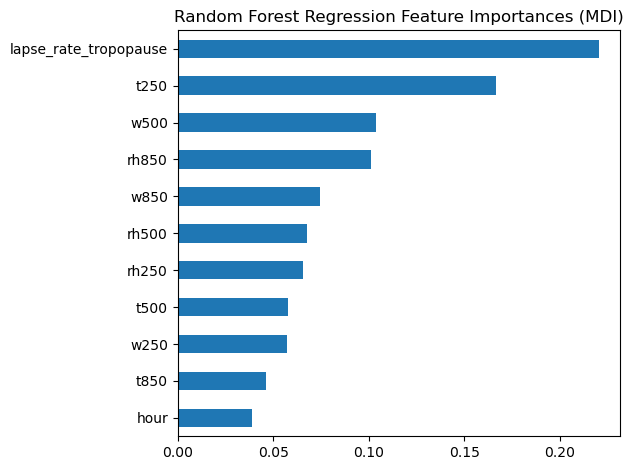

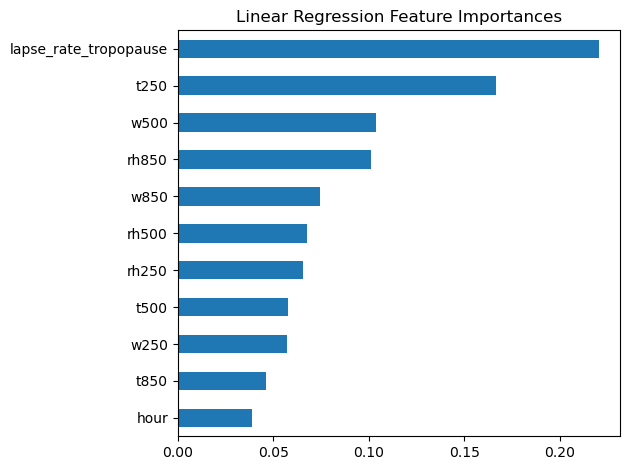

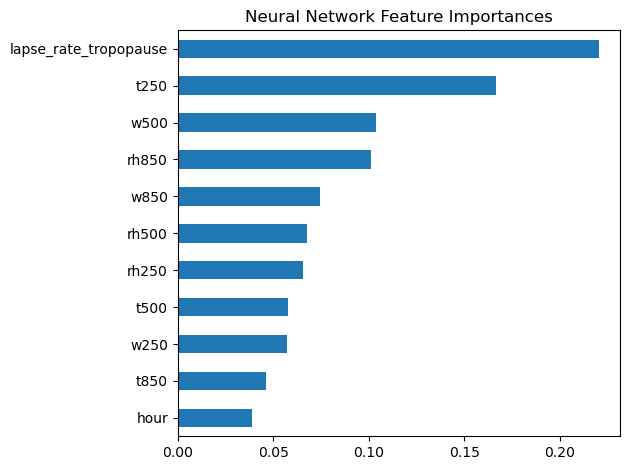

In [21]:
#Plot the feature importance for each model
feats = {}
for feature, importance in zip(features.columns, rf_regr.feature_importances_):
    feats[feature] = importance

mdi_importances = pd.Series(
    rf_regr[-1].feature_importances_, index=feats
).sort_values(ascending=True)
plt.figure()
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Regression Feature Importances (MDI)")
ax.figure.tight_layout()

feats2 = {}
for feature, importance in zip(features.columns, lin_regr.coef_):
    feats2[feature] = importance
plt.figure()
ax = mdi_importances.plot.barh()
ax.set_title("Linear Regression Feature Importances")
ax.figure.tight_layout()

feats3 = {}
for feature, importance in zip(features.columns, nn_regr.coefs_):
    feats3[feature] = importance
plt.figure()
ax = mdi_importances.plot.barh()
ax.set_title("Neural Network Feature Importances")
ax.figure.tight_layout()

In [22]:
#Try feature optimization to improve the models a bit

#Random Forest Regression
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'bootstrap': [True, False],  
'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],  
'max_features': ['auto', 'sqrt'],  
'min_samples_leaf': [1, 2, 4],  
'min_samples_split': [2, 5, 10],  
'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


random_forest_grid = RandomizedSearchCV(rf_regr, param_grid, n_iter = 30)

In [23]:
random_forest_grid.fit(X_train, Y_train)
rf_model = random_forest_grid.best_estimator_
from sklearn.metrics import r2_score, mean_squared_error
rf_predicted = rf_model.predict(X_test)
rf_r2 = r2_score(rf_predicted, Y_test)
rmse_rf = np.sqrt(mean_squared_error(rf_predicted, Y_test))

print(rf_r2, rmse_rf)

-2.8380226774162822 64.82730255237476


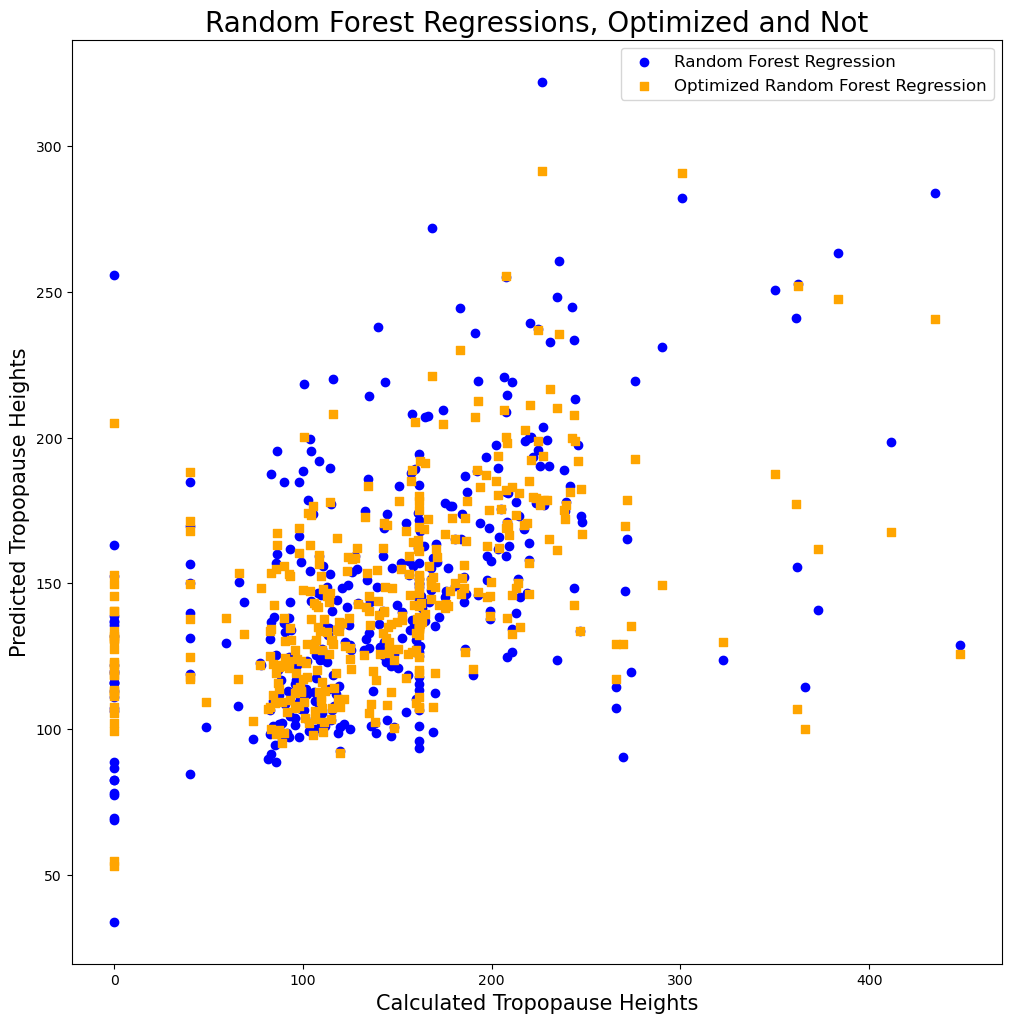

In [24]:
#Plot the old and the new data sets

plt.figure(figsize=(12,12))
plt.scatter(Y_test, rf_regr_predict, marker = "o", color='blue', label = 'Random Forest Regression')
plt.scatter(Y_test, rf_predicted, marker = "s", color='orange', label = 'Optimized Random Forest Regression')
plt.title('Random Forest Regressions, Optimized and Not', fontsize=20)
plt.xlabel('Calculated Tropopause Heights', fontsize=15)
plt.ylabel('Predicted Tropopause Heights', fontsize = 15)
plt.legend(loc='best', fontsize=12)